# MS002 Preprocess
09/26/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GitHub/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS002'
subj_format = ['edf']
subj_site = ['MSSM']


#### Import Data

In [13]:
edf_files = glob(f'{neural_dir}/MS002/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


In [14]:
mne_data

<RawEDF | MS002_SWB.edf, 276 x 2219008 (2167.0 s), ~4.56 GB, data loaded>

In [15]:
mne_data.ch_names

['LlOiF1',
 'LlOiF2',
 'LlOiF3',
 'LlOiF4',
 'LlOiF5',
 'LlOiF6',
 'LlOiF7',
 'LlOiF8',
 'LlOiF9',
 'LlOiF10',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LmOlF10',
 'LmOlF11',
 'LmOlF12',
 'LmOlF13',
 'LmOlF14',
 'RmOlF1',
 'RmOlF2',
 'RmOlF3',
 'RmOlF4',
 'RmOlF5',
 'RmOlF6',
 'RmOlF7',
 'RmOlF8',
 'RmOlF9',
 'RmOlF10',
 'RmOlF11',
 'RmOlF12',
 'LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'RaCaS1',
 'RaCaS2',
 'RaCaS3',
 'RaCaS4',
 'RaCaS5',
 'RaCaS6',
 'RaCaS7',
 'RaCaS8',
 'RaCaS9',
 'RaCaS10',
 'RaCaS11',
 'RaCaS12',
 'RaCaS13',
 'RaCaS14',
 'C63',
 'C64',
 'LalmS1',
 'LalmS2',
 'LalmS3',
 'LalmS4',
 'LalmS5',
 'LalmS6',
 'LalmS7',
 'LalmS8',
 'LalmS9',
 'LalmS10',
 'LalmS11',
 'LalmS12',
 'LalmS13',
 'LalmS14',
 'RalmS1',
 'RalmS2',
 'RalmS3',
 'RalmS4',
 'RalmS5',
 'RalmS6',
 'RalmS7',
 'RalmS8',
 'RalmS9',
 'RalmS10',
 'RalmS11',
 'R

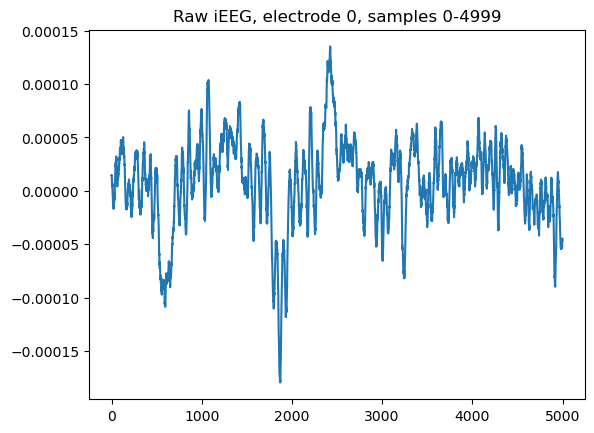

In [16]:
# Sanity check one channel data
plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Examine photodiode

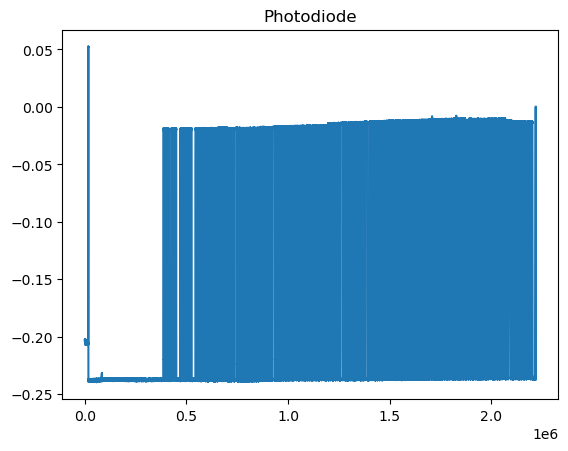

In [17]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

### Import Anat Recon Info - check all elecs are present in data + recon sheet


### Fix edf channel names

In [18]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}/MS002_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,Notes
0,LaCaS1,A32sg_L,-6.784557,49.555827,0.149337,-6.382462,37.158688,-3.130044,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus D,NaN,NaN
1,LaCaS10,A9l_L,-8.380923,61.155821,43.676991,-8.220073,48.757099,44.868611,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Medial Gyrus,L SFG,Left superior frontal gyrus 2 C,NaN,NaN
2,LaCaS11,A9l_L,-8.780014,62.355821,48.469026,-8.542609,49.887710,50.203768,Unknown,Left SFG superior frontal gyrus,Unknown,L Superior Medial Gyrus,L SFG,Left superior frontal gyrus 2 C,OOB,NaN
3,LaCaS12,Unknown,-8.780014,63.555820,53.261062,-8.436667,51.044299,55.539730,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
4,LaCaS2,A32sg_L,-6.784557,50.755827,4.941372,-6.368174,38.606223,2.270621,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus E,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,RmOIF5,A12/47o_R,33.922762,42.355831,-8.636061,34.666463,28.882016,-13.444118,White,Right Cerebral White Matter,Unknown,R IFG (p Orbitalis),R OrG,Right frontal orbital 4 D,WM,NaN
154,RmOIF6,A12/47l_R,37.913675,41.555831,-6.240044,38.716568,28.139395,-11.063832,Gray,Right Cerebral White Matter,Unknown,R IFG (p Orbitalis),R OrG,Right frontal orbital 4 D,NaN,NaN
155,RmOIF7,A12/47l_R,41.904589,40.755832,-3.844026,42.794042,27.279509,-8.584441,Gray,Right OrIFG orbital part of the inferior front...,Unknown,R IFG (p Orbitalis),R OrG,Right pars orbitalis C,NaN,NaN
156,RmOIF8,A12/47l_R,46.294594,39.555832,-1.048672,47.308597,25.926043,-5.816665,Gray,Right OrIFG orbital part of the inferior front...,Unknown,R IFG (p Orbitalis),R OrG,Right middle pars triangularis B,NaN,NaN


In [19]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LAgIT1',
 'LAgIT10',
 'LAgIT2',
 'LAgIT3',
 'LAgIT4',
 'LAgIT5',
 'LAgIT6',
 'LAgIT7',
 'LAgIT8',
 'LAgIT9',
 'LaImS1',
 'LaImS10',
 'LaImS11',
 'LaImS12',
 'LaImS13',
 'LaImS14',
 'LaImS2',
 'LaImS3',
 'LaImS4',
 'LaImS5',
 'LaImS6',
 'LaImS7',
 'LaImS8',
 'LaImS9',
 'LHplT1',
 'LHplT10',
 'LHplT11',
 'LHplT12',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LlOiF1',
 'LlOiF10',
 'LlOiF2',
 'LlOiF3',
 'LlOiF4',
 'LlOiF5',
 'LlOiF6',
 'LlOiF7',
 'LlOiF8',
 'LlOiF9',
 'LmOIF1',
 'LmOIF10',
 'LmOIF11',
 'LmOIF12',
 'LmOIF13',
 'LmOIF14',
 'LmOIF2',
 'LmOIF3',
 'LmOIF4',
 'LmOIF5',
 'LmOIF6',
 'LmOIF7',
 'LmOIF8',
 'LmOIF9',
 'LpIpS1',
 'LpIpS10',
 'LpIpS11',
 'LpIpS12',
 'LpIpS13',
 'LpIpS14',
 'LpIpS2',
 'LpIpS3',
 'LpIpS4',
 'LpIpS5',
 'LpIpS6',
 'LpIpS7',
 'LpIpS8',
 'LpIpS9',
 'LsiF1',
 'LsiF2',
 'LsiF3',
 

In [21]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file
       name  lev_score
274  lloif4   0.833333
275  lmolf4   0.833333
We have too many possible matches for lmoif4! Select one manually from these candidates:lmolf4
       name  lev_score
274  lloif1   0.833333
275  lmolf1   0.833333
We have too many possible matches for lmoif1! Select one manually from these candidates:lmolf1
       name  lev_score
274  lloif3   0.833333
275  lmolf3   0.833333
We have too many possible matches for lmoif3! Select one manually from these candidates:lmolf3
       name  lev_score
274  lloif5   0.833333
275  lmolf5   0.833333
We have too many possible matches for lmoif5! Select one manually from these candidates:lmolf5
        name  lev_score
274  lloif10   0.857143
275  lmolf10   0.857143
We have too many possible matches for lmoif10! Select one manually from these candidates:lmolf10
       name  lev_score
274  lloif7   0.833333
275  lmolf7   0.833333
We 

In [22]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [23]:
new_name_dict


{'LlOiF1': 'lloif1',
 'LlOiF2': 'lloif2',
 'LlOiF3': 'lloif3',
 'LlOiF4': 'lloif4',
 'LlOiF5': 'lloif5',
 'LlOiF6': 'lloif6',
 'LlOiF7': 'lloif7',
 'LlOiF8': 'lloif8',
 'LlOiF9': 'lloif9',
 'LlOiF10': 'lloif10',
 'LmOlF1': 'lmoif1',
 'LmOlF2': 'lmoif2',
 'LmOlF3': 'lmoif3',
 'LmOlF4': 'lmoif4',
 'LmOlF5': 'lmoif5',
 'LmOlF6': 'lmoif6',
 'LmOlF7': 'lmoif7',
 'LmOlF8': 'lmoif8',
 'LmOlF9': 'lmoif9',
 'LmOlF10': 'lmoif10',
 'LmOlF11': 'lmoif11',
 'LmOlF12': 'lmoif12',
 'LmOlF13': 'lmoif13',
 'LmOlF14': 'lmoif14',
 'RmOlF1': 'rmoif1',
 'RmOlF2': 'rmoif2',
 'RmOlF3': 'rmoif3',
 'RmOlF4': 'rmoif4',
 'RmOlF5': 'rmoif5',
 'RmOlF6': 'rmoif6',
 'RmOlF7': 'rmoif7',
 'RmOlF8': 'rmoif8',
 'RmOlF9': 'rmoif9',
 'RmOlF10': 'rmoif10',
 'RmOlF11': 'rmoif11',
 'RmOlF12': 'rmoif12',
 'LaCaS1': 'lacas1',
 'LaCaS2': 'lacas2',
 'LaCaS3': 'lacas3',
 'LaCaS4': 'lacas4',
 'LaCaS5': 'lacas5',
 'LaCaS6': 'lacas6',
 'LaCaS7': 'lacas7',
 'LaCaS8': 'lacas8',
 'LaCaS9': 'lacas9',
 'LaCaS10': 'lacas10',
 'LaCaS11': 'l

In [24]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS002_SWB.edf, 276 x 2219008 (2167.0 s), ~4.56 GB, data loaded>

In [25]:
unmatched_seeg #make sure there are no unmatched names


[]

In [26]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['c63', 'c64', 'c125', 'c126', 'c127', 'c128', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'c186', 'c187', 'c188', 'c189', 'c190', 'c191', 'c192', 'c193', 'c194', 'c195', 'c196', 'c197', 'c198', 'c199', 'c200', 'c201', 'c202', 'c203', 'c204', 'c205', 'c206', 'c207', 'c208', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', 'c219', 'c220', 'c221', 'c222', 'c223', 'c224', 'c225', 'c226', 'c227', 'c228', 'c229', 'c230', 'c231', 'c232', 'c233', 'c234', 'c235', 'c236', 'c237', 'c238', 'c239', 'c240', 'c241', 'c242', 'c243', 'c244', 'c245', 'c246', 'c247', 'c248', 'c249', 'c250', 'c251', 'c252', 'c253', 'c254', 'c255', 'c256', 'dc1', 'dc2', 'dc3', 'dc4', 'dc5', 'dc6', 'dc7', 'dc8', 'dc9', 'dc10', 'dc11', 'dc12', 'dc13', 'dc14', 'dc15', 'dc16', 'trig', 'osat', 'pr', 'pleth']


In [27]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of', len(left_seeg_names), 'left &', len(right_seeg_names), 'right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')


We have a total of 94 left & 64 right sEEG electrodes
We have a total of 158 sEEG electrodes


In [28]:
list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['dc1'])) #list of non seeg/photodiode channels

['f3',
 'c209',
 'pz',
 'c202',
 'dc8',
 'c256',
 'dc3',
 'c212',
 't4',
 'dc6',
 'c213',
 'c127',
 'p3',
 'c237',
 'dc7',
 'c236',
 'dc15',
 'c252',
 'c63',
 'c64',
 'c249',
 'c241',
 'c208',
 'c201',
 'c199',
 'c195',
 'c187',
 'c200',
 'c125',
 'dc5',
 'c205',
 'c211',
 'c219',
 'c251',
 'dc14',
 'c231',
 'c207',
 'c253',
 'pr',
 'c204',
 'c198',
 't3',
 'ekg2',
 'c191',
 'c206',
 'cz',
 'c192',
 'c190',
 'c224',
 'c4',
 'c217',
 'c3',
 'c233',
 'c128',
 'f8',
 'f4',
 'p4',
 'c221',
 'c229',
 'c215',
 'c196',
 'c255',
 'f7',
 'c126',
 'c250',
 'dc2',
 'c220',
 'c246',
 'osat',
 'c232',
 'c222',
 'c230',
 'c235',
 'dc9',
 'c242',
 'dc13',
 'o1',
 'c247',
 't6',
 'o2',
 'c193',
 'fp1',
 'c186',
 'c225',
 'dc4',
 'c234',
 'dc11',
 'c223',
 'c228',
 'c214',
 'pleth',
 'c254',
 'c245',
 't5',
 'c238',
 'trig',
 'ekg1',
 'fz',
 'c226',
 'dc16',
 'c188',
 'c239',
 'c243',
 'c194',
 'c216',
 'c218',
 'c197',
 'c210',
 'dc10',
 'c227',
 'c240',
 'c203',
 'c248',
 'fp2',
 'dc12',
 'c189',
 'c

In [29]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['dc1']))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs + 1 (photodiode)

<RawEDF | MS002_SWB.edf, 159 x 2219008 (2167.0 s), ~2.63 GB, data loaded>

In [30]:
# Set channel types:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
trig_mapping_dict = {'dc1':'stim'} 
mne_data.set_channel_types(sEEG_mapping_dict)
mne_data.set_channel_types(trig_mapping_dict)

<RawEDF | MS002_SWB.edf, 159 x 2219008 (2167.0 s), ~2.63 GB, data loaded>

In [31]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS002_SWB.edf, 159 x 2219008 (2167.0 s), ~2.63 GB, data loaded>

### Notch filter line noise

In [32]:
# Identify line noise
mne_data.info['line_freq'] = 60

# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 158 out of 158 | elapsed:    8.6s finished


<RawEDF | MS002_SWB.edf, 159 x 2219008 (2167.0 s), ~2.63 GB, data loaded>

### Resampling data 

In [33]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 159 out of 159 | elapsed:   14.7s finished


<RawEDF | MS002_SWB.edf, 159 x 1083500 (2167.0 s), ~1.28 GB, data loaded>

### Save out photodiode data
Note: this is after filtering out line noise and resampling

In [30]:
mne_data.save(f'{neural_dir}/MS002/photodiode.fif', picks='dc1', overwrite=True)

In [34]:
mne_data.drop_channels('dc1')

<RawEDF | MS002_SWB.edf, 158 x 1083500 (2167.0 s), ~1.28 GB, data loaded>

### Bad Channel Removal (automated + manual inspection)

In [74]:
### I skip this step because it doesn't work for me 

# bads = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)
# bads
# mne_data.info['bads'] = bads
#9/26/23 - too strict, manually overriding 

In [25]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [26]:
probe_names

array(['lacas', 'lagit', 'laims', 'lhplt', 'lloif', 'lmoif', 'lpips',
       'lsif', 'racas', 'ragit', 'raims', 'rhplt', 'rmoif'], dtype='<U5')

In [27]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [28]:
probe_ch_counts

{'lacas': 12,
 'lagit': 10,
 'laims': 14,
 'lhplt': 12,
 'lloif': 10,
 'lmoif': 14,
 'lpips': 14,
 'lsif': 8,
 'racas': 14,
 'ragit': 12,
 'raims': 14,
 'rhplt': 12,
 'rmoif': 12}

<IPython.core.display.Javascript object>


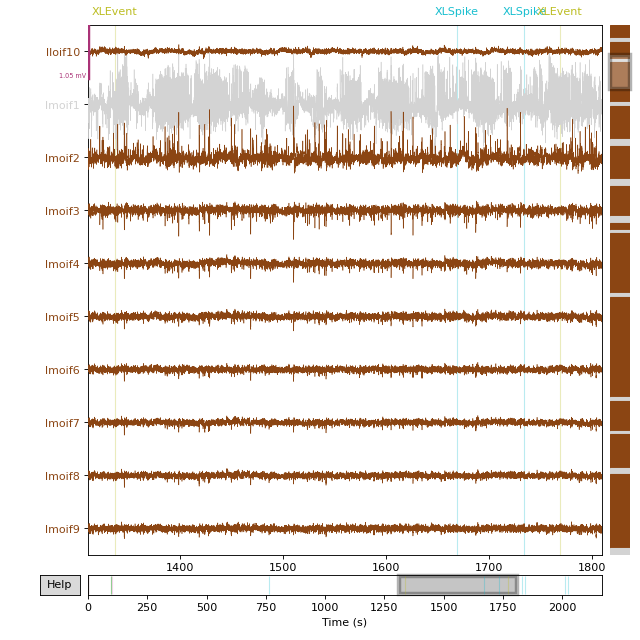

<IPython.core.display.Javascript object>


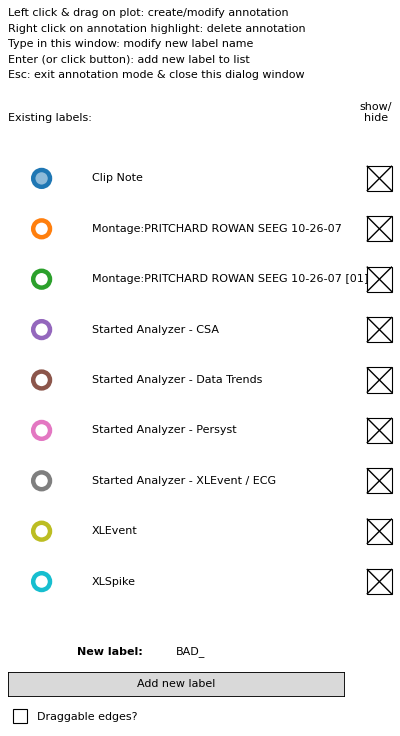

In [44]:
%matplotlib notebook 
fig = mne_data.plot(start=0, duration=500, n_channels=10, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

<IPython.core.display.Javascript object>


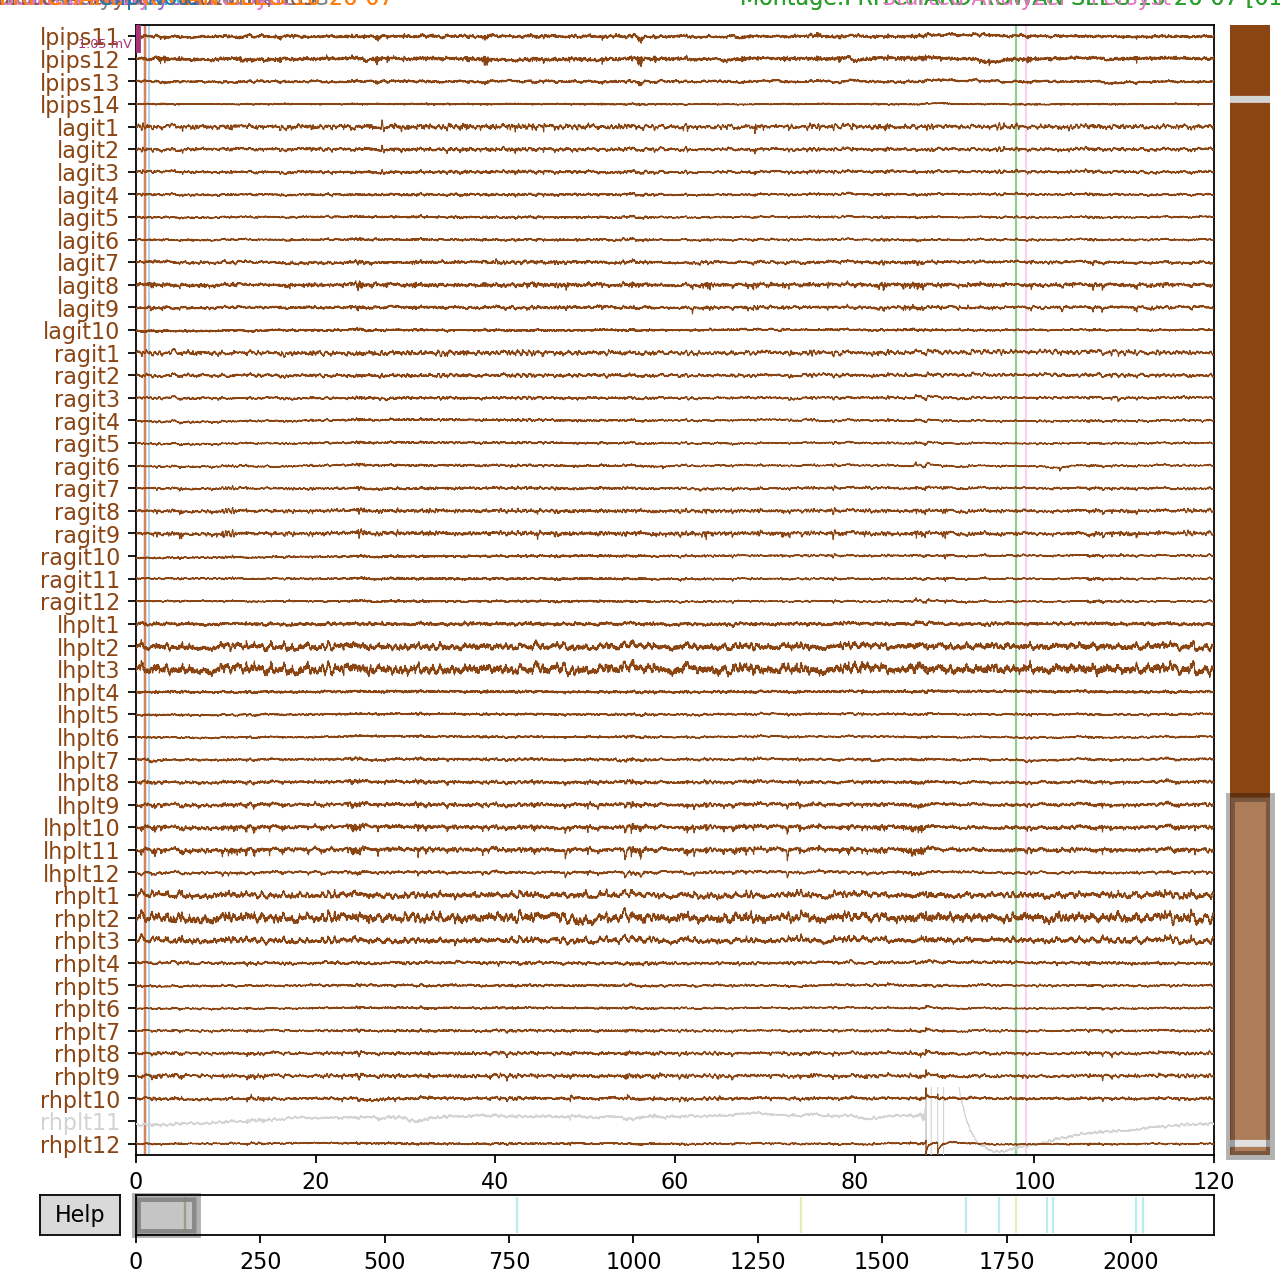

<IPython.core.display.Javascript object>


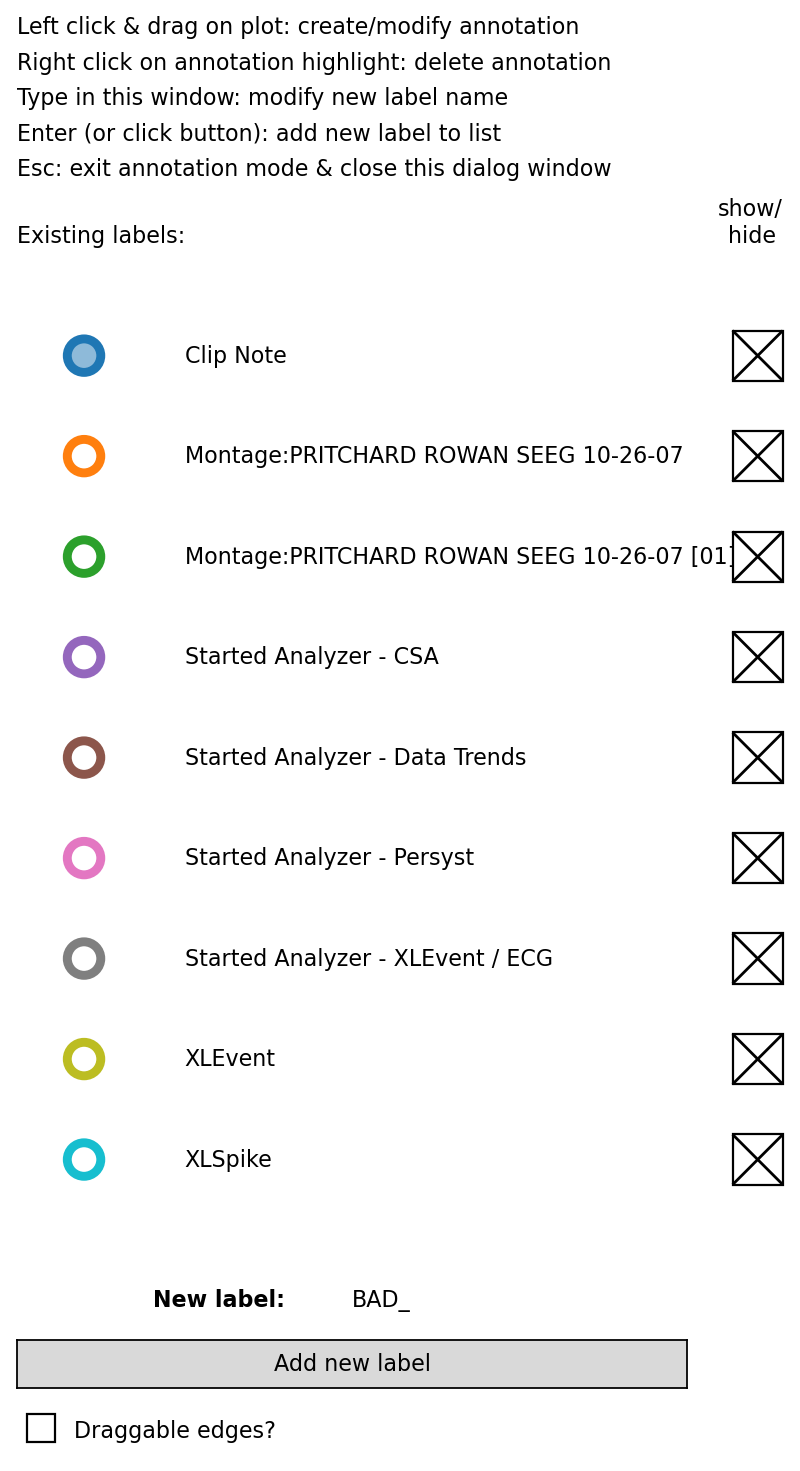

In [34]:
%matplotlib notebook
fig = mne_data.plot(start=0, duration=120, n_channels=50, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

In [35]:
mne_data.info['bads'] = ['lmoif1', 'rhplt11']

In [107]:
#if plot is being buggy - manually set bads

#ms002_bad_ch = ['rhplt11', 'lmoif1']
#mne_data.info['bads'] = ms002_bad_ch 

In [36]:
mne_data.info['bads']

['lmoif1', 'rhplt11']

In [36]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 2 items (lmoif1, rhplt11)
 ch_names: lloif1, lloif2, lloif3, lloif4, lloif5, lloif6, lloif7, lloif8, ...
 chs: 158 sEEG
 custom_ref_applied: False
 dig: 158 items (158 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: 2001-01-01 15:59:08 UTC
 nchan: 158
 projs: []
 sfreq: 500.0 Hz
>

## Save raw LFP data
Notch filtered and resampled with bad elecs indicated

In [37]:
#define oob elecs as bad before saving out lfp file 
oob_elec = [elec_locs['label'].iloc[ind].lower() for ind, data in elec_locs['ManualExamination'].str.lower().items() if data=='oob']
oob_elec

['lacas11',
 'lacas12',
 'lagit10',
 'lloif5',
 'lmoif14',
 'lpips14',
 'racas10',
 'racas11',
 'racas14',
 'ragit11',
 'ragit12',
 'raims5',
 'rhplt12',
 'rmoif11',
 'rmoif12']

In [42]:
bad_ch= ['rhplt11', 'lmoif1'] #or =mne_data.info['bads']
bad_ch = bad_ch + oob_elec
mne_data.info['bads'] = bad_ch
mne_data.info['bads']

['rhplt11',
 'lmoif1',
 'lacas11',
 'lacas12',
 'lagit10',
 'lloif5',
 'lmoif14',
 'lpips14',
 'racas10',
 'racas11',
 'racas14',
 'ragit11',
 'ragit12',
 'raims5',
 'rhplt12',
 'rmoif11',
 'rmoif12']

In [73]:
mne_data.save(f'{neural_dir}/MS002/raw_ieeg.fif',overwrite=True)

# Rereference data - Both WM ref and Bipolar ref!

In [7]:
mne_data = mne.io.read_raw_fif(f'{neural_dir}/MS002/raw_ieeg.fif')

In [9]:
elec_locs.ManualExamination

0      NaN
1      NaN
2      OOB
3      OOB
4      NaN
      ... 
153     WM
154    NaN
155    NaN
156    NaN
157    NaN
Name: ManualExamination, Length: 158, dtype: object

### WM REF

In [39]:
anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.wm_ref(mne_data=mne_data, 
                                                                                elec_path=anat_file, 
                                                                                unmatched_seeg = unmatched_seeg,
                                                                                bad_channels=mne_data.info['bads'],
                                                                                      site = 'MSSM')

In [40]:
mne_data_wm_reref = mne.set_bipolar_reference(mne_data, 
                      anode=anode_list, 
                      cathode=cathode_list,
                      copy=True)

In [ ]:
mne_data_reref.drop_channels([x for x in mne_data_reref.ch_names if '-' not in x])

In [45]:
mne_data_wm_reref.ch_names

['lloif5',
 'lloif6',
 'lmoif4',
 'lmoif7',
 'lmoif14',
 'rmoif5',
 'rmoif11',
 'rmoif12',
 'lacas9',
 'lacas11',
 'lacas12',
 'racas4',
 'racas5',
 'racas10',
 'racas11',
 'racas14',
 'laims7',
 'laims8',
 'laims9',
 'raims5',
 'raims7',
 'raims9',
 'raims10',
 'lsif3',
 'lsif5',
 'lpips5',
 'lpips7',
 'lpips9',
 'lpips14',
 'lagit6',
 'lagit8',
 'lagit10',
 'ragit5',
 'ragit11',
 'ragit12',
 'lhplt5',
 'lhplt6',
 'rhplt4',
 'rhplt5',
 'rhplt7',
 'rhplt12',
 'lacas1-lmoif3',
 'lacas10-laims14',
 'lacas2-lmoif5',
 'lacas3-lmoif5',
 'lacas4-lmoif5',
 'lacas5-lmoif6',
 'lacas6-laims10',
 'lacas7-laims10',
 'lacas8-laims14',
 'lagit1-lagit5',
 'lagit2-lagit5',
 'lagit3-lagit5',
 'lagit4-lagit5',
 'lagit7-lagit5',
 'lagit9-lagit5',
 'laims1-lloif4',
 'laims11-laims14',
 'laims12-laims14',
 'laims13-lpips12',
 'laims2-lloif4',
 'laims3-lloif4',
 'laims4-lloif4',
 'laims5-lsif1',
 'laims6-lsif1',
 'lhplt1-lagit5',
 'lhplt10-lhplt8',
 'lhplt11-lhplt8',
 'lhplt12-lhplt8',
 'lhplt2-lagit5',
 'l

<IPython.core.display.Javascript object>


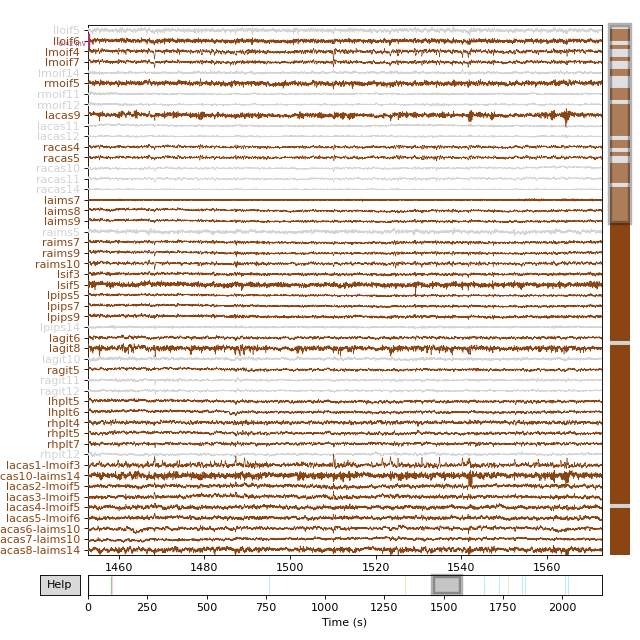

<IPython.core.display.Javascript object>


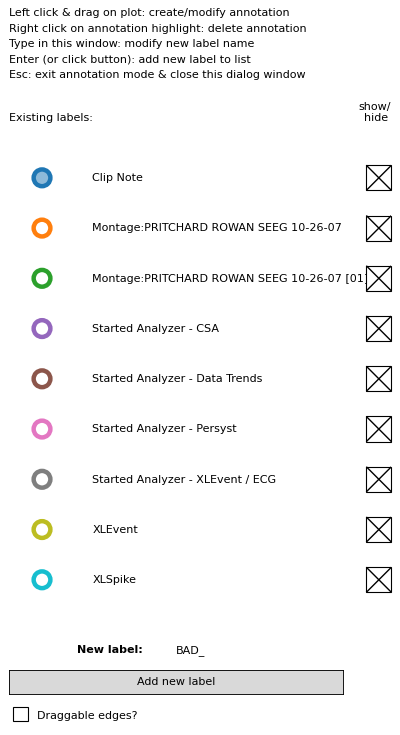

In [46]:
%matplotlib notebook
fig = mne_data_wm_reref.plot(start=0, duration=120, n_channels=50, scalings=mne_data._data.max()/50)
fig.fake_keypress('a')

###  BIPOLAR REF

In [92]:
anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.bipolar_ref(elec_path=anat_file, 
                                       bad_channels=mne_data.info['bads'], 
                                       unmatched_seeg=unmatched_seeg,
                                       site='MSSM')

In [94]:
mne_data_bp_reref = mne.set_bipolar_reference(mne_data, 
                      anode=anode_list, 
                      cathode=cathode_list,
                      copy=True)

In [95]:
mne_data_bp_reref

<RawEDF | MS002_SWB.edf, 145 x 1083500 (2167.0 s), ~1.17 GB, data loaded>

<IPython.core.display.Javascript object>


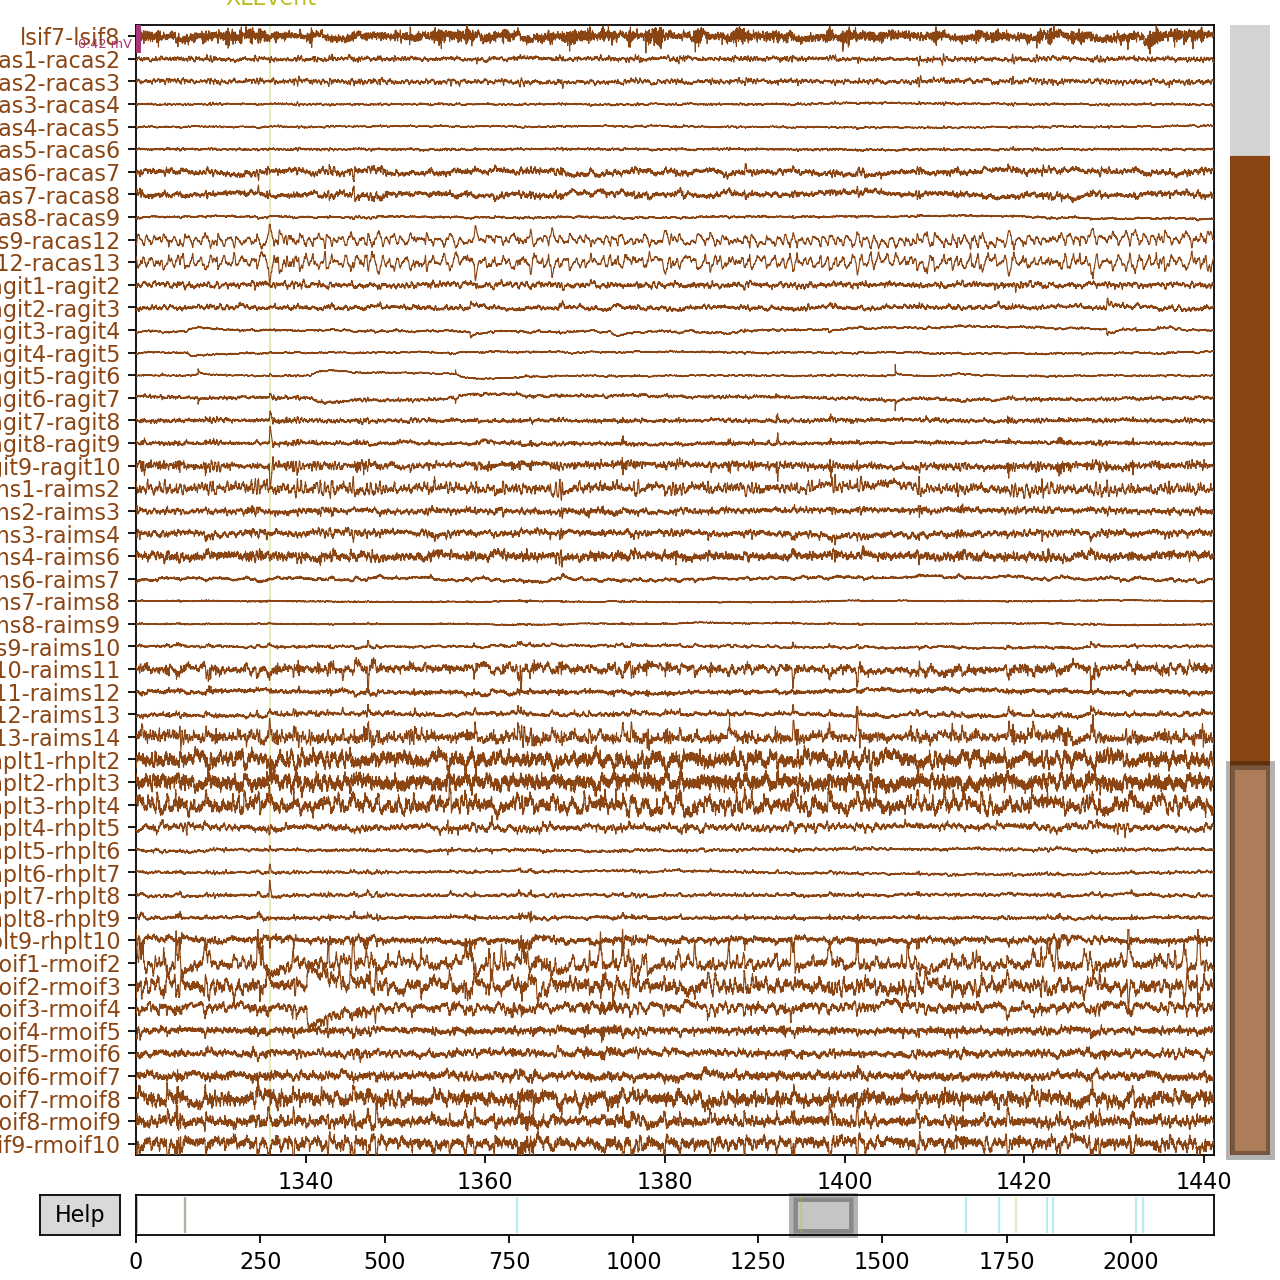

<IPython.core.display.Javascript object>


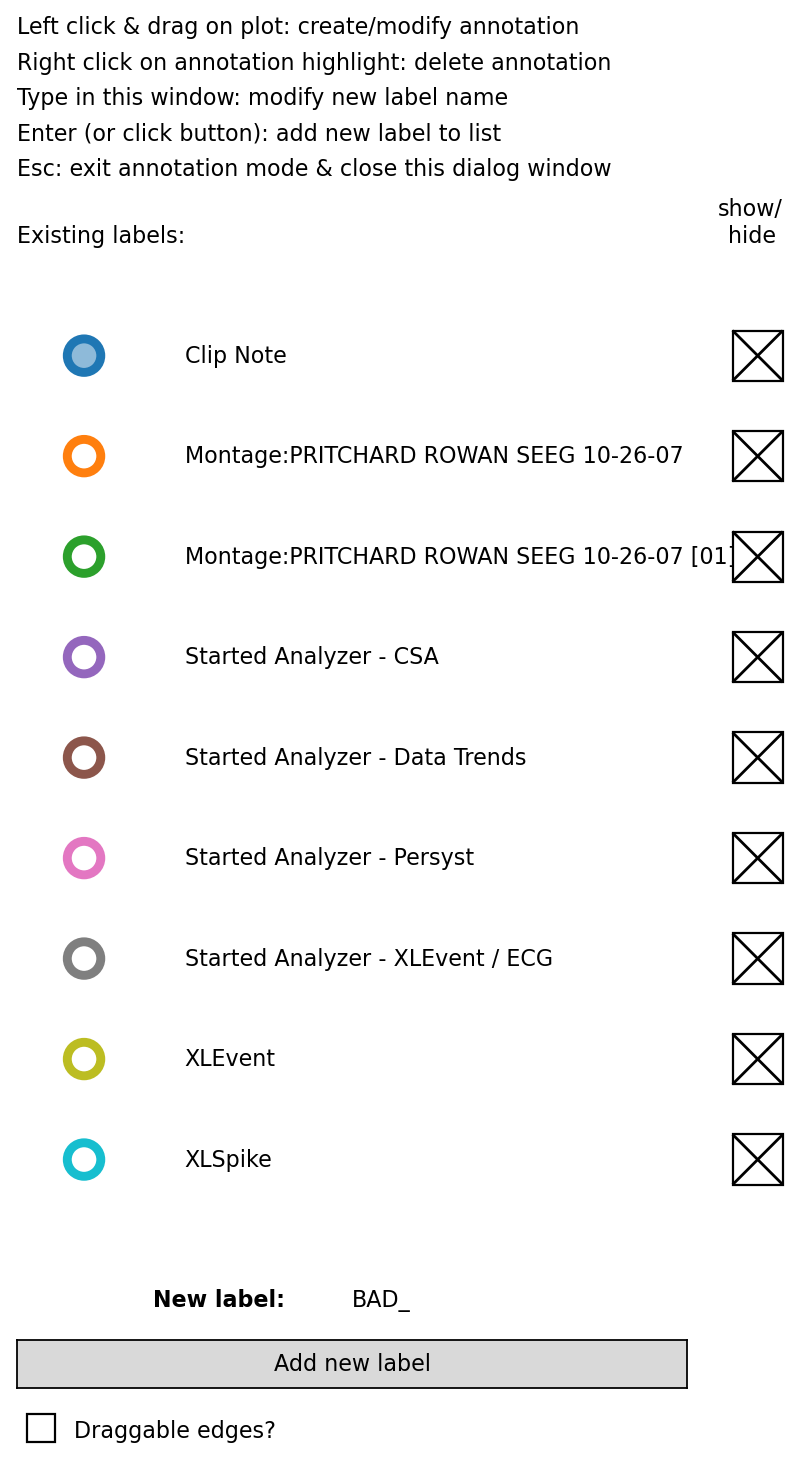

In [98]:
%matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=120, n_channels=50, scalings=mne_data._data.max()/50)
fig.fake_keypress('a')

## Save reref data

In [99]:
mne_data_wm_reref.save(f'{neural_dir}/MS002/wm_ref_ieeg.fif',overwrite=True)

In [100]:
mne_data_bp_reref.save(f'{neural_dir}/MS002/bp_ref_ieeg.fif',overwrite=True)